In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']

In [3]:
epochs_ica_folder = 'gameemo_database_epochs_ica'
current_dir = epochs_ica_folder 
labels_path = 'GameLabels\GAMEEMO_SCORES.xlsx'
labels_sheet = 'All'
labels_file = pd.read_excel(labels_path, labels_sheet)
labels_file.head(2)

,Subject,Boring,Horrible,Calm,Funny
0,1,8,1,3,2
1,1,2,1,8,8


In [4]:
labels_array = np.array(labels_file[['Boring', 'Horrible', 'Calm', 'Funny']])
labels_array[0]

array([8, 1, 3, 2], dtype=int64)

In [6]:
from scipy.signal import spectrogram as spg
from scipy.signal import stft

In [24]:
# Parameters
sampling_rate = 128  # Adjust based on the actual sampling rate of your data
nperseg = 32  # Number of samples per segment

In [25]:
def compute_stft(signal, sampling_rate, nperseg):
    stft_matrices = []
    for i in range(signal.shape[0]):  # Loop over each channel
        f, t, Zxx = stft(signal[i, :], fs=sampling_rate, nperseg=nperseg)
        stft_matrices.append(Zxx)
    return f, t, np.stack(stft_matrices, axis=-1)

In [26]:
subject = os.listdir(current_dir)[0]
game = os.listdir(os.path.join(current_dir, subject))[0]
epoch = os.listdir(os.path.join(current_dir, subject, game))[0]
read_epoch = pd.read_csv(os.path.join(current_dir, subject, game, epoch))

In [27]:
read_epoch = read_epoch[channels].T.values
print(read_epoch.shape)

(14, 641)


In [28]:
f, t, spectrogram = compute_stft(read_epoch, sampling_rate, nperseg)

In [29]:
spectrogram.shape

(17, 42, 14)

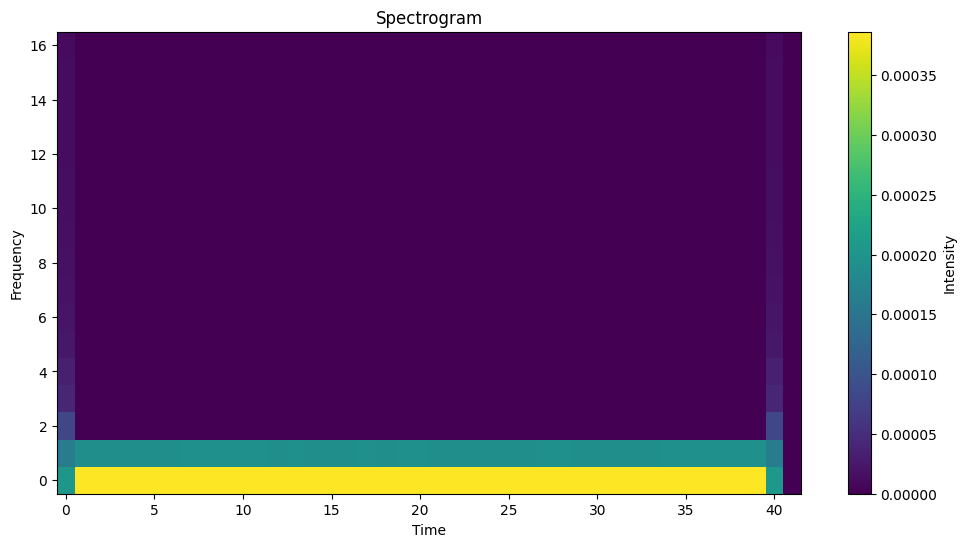

In [30]:
# Plot the spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(spectrogram[:, :, 1]), aspect='auto', cmap='viridis', origin='lower')
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label='Intensity')
plt.show()

In [32]:
epochs_data = []
labels_data = []

k=0

for subject in tqdm(os.listdir(current_dir)):
    for game in os.listdir(os.path.join(current_dir, subject)):
        k+=1
        for epoch in os.listdir(os.path.join(current_dir, subject, game)):
            read_epoch = pd.read_csv(os.path.join(current_dir, subject, game, epoch))
            read_epoch = read_epoch[channels].T.values
            f, t, spectrogram = compute_stft(read_epoch, sampling_rate, nperseg)
            epochs_data.append(np.array(spectrogram))
            labels_data.append(labels_array[k-1])

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [01:12<00:00,  2.59s/it]


In [33]:
print((epochs_data[0].shape), (labels_data[0].shape))

(17, 42, 14) (4,)


In [34]:
main_data = np.array(epochs_data)
main_labels = np.array(labels_data)
print(main_data.shape, main_labels.shape)

(6608, 17, 42, 14) (6608, 4)


In [35]:
row_size = main_data.shape[1]
col_size = main_data.shape[2]
print(row_size, col_size)

17 42


In [36]:
from sklearn.model_selection import train_test_split

# First, split into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(main_data, main_labels, test_size=0.2, random_state=42)

# Then, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (3964, 17, 42, 14) (3964, 4)
Validation set shape: (1322, 17, 42, 14) (1322, 4)
Testing set shape: (1322, 17, 42, 14) (1322, 4)


In [37]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [38]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [39]:
# def EEGNet(nb_classes = 4, Chans = 14, Samples = 129, 
#              dropoutRate = 0.5, kernLength = 64, F1 = 8, 
#              D = 4, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
def EEGNet(nb_classes = 4, Row_size = row_size, Col_size = col_size, Chans = 14, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 4, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input_main   = Input((row_size, col_size, Chans))
    block1       = Conv2D(25, (5, 5), padding='same',
                                 input_shape=(row_size, col_size, Chans),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    # block1       = Conv2D(25, (Chans, 1),
    #                              kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(1, 1))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (5, 5), padding='same',
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(1, 1))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (5, 5), padding='same',
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(1, 1))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (5, 5), padding='same',
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    # block4       = Conv2D(25, (Chans, 1),
    #                              kernel_constraint = max_norm(2., axis=(0,1,2)))(block4)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.9)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(2, 2), padding='same',strides=(1, 1))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    output      = Activation('linear')(dense)
    
    return Model(inputs=input_main, outputs=output)


In [40]:
eegnet_model = EEGNet()

In [41]:
eegnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17, 42, 14)]      0         
                                                                 
 conv2d (Conv2D)             (None, 17, 42, 25)        8775      
                                                                 
 batch_normalization (BatchN  (None, 17, 42, 25)       100       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 17, 42, 25)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 42, 25)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 17, 42, 25)        0     

In [42]:
eegnet_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [43]:
eegnet_model.fit(X_train, y_train, epochs=400, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/400
248/248 [==============================] - 9s 16ms/step - loss: 24.9779 - accuracy: 0.2921 - val_loss: 15.4615 - val_accuracy: 0.2504
Epoch 2/400
248/248 [==============================] - 3s 13ms/step - loss: 12.9268 - accuracy: 0.2921 - val_loss: 12.6198 - val_accuracy: 0.2542
Epoch 3/400
248/248 [==============================] - 3s 13ms/step - loss: 11.2072 - accuracy: 0.3136 - val_loss: 12.8290 - val_accuracy: 0.2436
Epoch 4/400
248/248 [==============================] - 3s 13ms/step - loss: 9.3108 - accuracy: 0.3537 - val_loss: 10.1422 - val_accuracy: 0.2315
Epoch 5/400
248/248 [==============================] - 3s 13ms/step - loss: 8.4012 - accuracy: 0.3671 - val_loss: 7.5045 - val_accuracy: 0.4070
Epoch 6/400
248/248 [==============================] - 3s 13ms/step - loss: 7.6347 - accuracy: 0.4024 - val_loss: 9.0605 - val_accuracy: 0.3116
Epoch 7/400
248/248 [==============================] - 3s 13ms/step - loss: 7.9302 - accuracy: 0.3925 - val_loss: 7.4299 - val_ac

In [44]:
y_pred = eegnet_model.predict(X_test)

42/42 [==============================] - 1s 7ms/step


In [45]:
y_pred

array([[ 1.8654947,  0.7841759,  3.84122  ,  8.139906 ],
       [ 1.7992768,  2.7712681,  2.3457184,  6.6799164],
       [ 1.5766071,  1.2346979,  6.673357 ,  7.4622793],
       ...,
       [ 1.6672094,  7.6444197,  3.1600943,  2.7504466],
       [ 0.8327694, 10.569219 ,  2.362435 ,  1.0083494],
       [ 1.3457086,  7.071151 ,  5.1842628,  2.5765576]], dtype=float32)

In [46]:
y_test

array([[ 1,  1,  3,  9],
       [ 1,  1,  2,  8],
       [ 1,  1,  8,  8],
       ...,
       [ 1,  9,  4,  1],
       [ 1, 10,  1,  1],
       [ 1,  5,  7,  1]], dtype=int64)